# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services


## Table of Contents

0. [Introduction](#intro)<br>
    0.1 [Get to Know the Data](#data)<br>
    
1. [Customer Segmentation Report](#customer)<br> 
    1.1 [Preprocessing](#preprocessing)<br>   
    1.2 [Assess Mining Data](#assess)<br>   
    1.3 [Creating a Cleaning Function](#clean)<br> 
    
2. [Feature Transformation](#feature)<br>   
    2.1 [Dimensionality Reduction](#reduction)<br>   
    2.2 [Principal Components Interpretation](#principal)<br>  
   
3. [Clustering](#clustering)<br>   
    3.1 [Applying Clustering to General Pupulation Data using k-means](#kmeans)<br>   
    3.2 [Applying all Steps to Customer Data](#customer)<br> 
    
4. [Supervised Learning Model](#model)<br>   
    4.1 [Model training](#training)<br>
    4.2 [Model Tuning](#tuning)<br>
    4.3 [Feature Importance](#importance)<br>

<a id='intro'></a>

### Part 0. Introduction

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [30]:

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ast
# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA 
import pprint
from sklearn.cluster import KMeans
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

<a id='data'></a>
### 0.1 Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [9]:
from shutil import copyfile

copyfile('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', 'Udacity_AZDIAS_052018.csv')

'Udacity_AZDIAS_052018.csv'

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})

In [3]:
# Structure of the general population  data

azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
feat_info = pd.read_csv("feat_info.csv")

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [62]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_list = feat_info['attribute'].tolist()

In [6]:
diff_not_in_feat = list(set(feat_list) - set(azdias))
print('Features in feat_list that are not in azdias:')
print(len(diff_not_in_feat))
print(diff_not_in_feat)
print('***')

# features that are not in feat_info (no information regarding type)
diff_not_in_azdias = list(set(azdias) - set(feat_list))
print('Features in azdias that are not in feat_list:')
print(len(diff_not_in_azdias))
print(diff_not_in_azdias)
print('***')

# should be ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']
diff_customers_azdias = list(set(customers) - set(azdias))
print('Features in customers that are not in azdias:')
print(len(diff_customers_azdias))
print(diff_customers_azdias)
print('***')

Features in feat_list that are not in azdias:
11
['D19_TELKO_ ANZ_24', 'D19_VERSI_ ANZ_24', 'GEOSCORE_KLS7', 'D19_VERSAND_ ANZ_12 ', 'D19_VERSI_ ANZ_12 ', 'D19_VERSAND_ ANZ_24', 'KBA13_CCM_1400_2500', 'PLZ', 'HAUSHALTSSTRUKTUR', 'WACHSTUMSGEBIET_NB', 'D19_TELKO_ ANZ_12']
***
Features in azdias that are not in feat_list:
53
['GEMEINDETYP', 'UNGLEICHENN_FLAG', 'RT_KEIN_ANREIZ', 'RT_UEBERGROESSE', 'KBA13_ANTG1', 'CJT_TYP_4', 'VERDICHTUNGSRAUM', 'ALTER_KIND3', 'KOMBIALTER', 'LNR', 'CJT_TYP_2', 'UMFELD_ALT', 'VK_DISTANZ', 'CJT_KATALOGNUTZER', 'VK_DHT4A', 'VHA', 'ANZ_KINDER', 'KBA13_BAUMAX', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_KONSUMTYP_MAX', 'D19_TELKO_ONLINE_QUOTE_12', 'KBA13_HHZ', 'KBA13_ANTG4', 'D19_LETZTER_KAUF_BRANCHE', 'KBA13_CCM_1401_2500', 'VK_ZG11', 'KBA13_GBZ', 'KBA13_ANTG3', 'RT_SCHNAEPPCHEN', 'ALTER_KIND1', 'CJT_TYP_5', 'EINGEFUEGT_AM', 'UMFELD_JUNG', 'ALTER_KIND4', 'KBA13_ANTG2', 'DSL_FLAG', 'D19_VERSI_ONLINE_QUOTE_12', 'CJT_TYP_1', 'FIRMENDICHTE', 'KONSUMZELLE', 'CJT_TYP_6', 'E

In [13]:
diff_not_in_customers = list(set(customers) - set(feat_list))
print('Features in customers that are not in feat_list:')
print(len(diff_not_in_customers))
print(diff_not_in_customers)
print('***')

Features in customers that are not in feat_list:
56
['MOBI_RASTER', 'CUSTOMER_GROUP', 'D19_SOZIALES', 'ALTERSKATEGORIE_FEIN', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEZOGENAM_HH_JAHR', 'UNGLEICHENN_FLAG', 'PRODUCT_GROUP', 'CJT_TYP_1', 'RT_SCHNAEPPCHEN', 'VK_DISTANZ', 'FIRMENDICHTE', 'EXTSEL992', 'VERDICHTUNGSRAUM', 'D19_TELKO_ONLINE_QUOTE_12', 'ALTER_KIND1', 'EINGEFUEGT_AM', 'RT_KEIN_ANREIZ', 'CJT_KATALOGNUTZER', 'VHN', 'ANZ_STATISTISCHE_HAUSHALTE', 'AKT_DAT_KL', 'KBA13_ANTG2', 'VHA', 'ALTER_KIND3', 'ALTER_KIND4', 'CJT_TYP_4', 'CJT_TYP_2', 'CJT_TYP_3', 'UMFELD_JUNG', 'KBA13_BAUMAX', 'KBA13_HHZ', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG3', 'LNR', 'RT_UEBERGROESSE', 'KBA13_ANTG4', 'CJT_TYP_6', 'KONSUMZELLE', 'ONLINE_PURCHASE', 'KBA13_CCM_1401_2500', 'CJT_TYP_5', 'DSL_FLAG', 'KBA13_GBZ', 'STRUKTURTYP', 'ALTER_KIND2', 'VK_DHT4A', 'ANZ_KINDER', 'KBA13_KMH_210', 'D19_VERSI_ONLINE_QUOTE_12', 'KOMBIALTER', 'UMFELD_ALT', 'VK_ZG11', 'D19_KONSUMTYP_MAX', 'GEMEINDETYP']
***


In [ ]:
# drop features
azdias.drop(labels=diff_not_in_azdias, axis=1, inplace=True)

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [78]:
azdias.shape

(891221, 313)

In [17]:
azdias.isnull().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

In [32]:
azdias.isnull().sum().sum()



33492923

In [63]:
feat_info.set_index(['attribute'], inplace=True)

In [64]:
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [64]:
azdias.shape

(891221, 313)

In [79]:
unknown = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info['attribute'])
unknown

attribute
AGER_TYP                         [-1,0]
ALTERSKATEGORIE_GROB           [-1,0,9]
ANREDE_KZ                        [-1,0]
CJT_GESAMTTYP                       [0]
FINANZ_MINIMALIST                  [-1]
FINANZ_SPARER                      [-1]
FINANZ_VORSORGER                   [-1]
FINANZ_ANLEGER                     [-1]
FINANZ_UNAUFFAELLIGER              [-1]
FINANZ_HAUSBAUER                   [-1]
FINANZTYP                          [-1]
GEBURTSJAHR                         [0]
GFK_URLAUBERTYP                      []
GREEN_AVANTGARDE                     []
HEALTH_TYP                       [-1,0]
LP_LEBENSPHASE_FEIN                 [0]
LP_LEBENSPHASE_GROB                 [0]
LP_FAMILIE_FEIN                     [0]
LP_FAMILIE_GROB                     [0]
LP_STATUS_FEIN                      [0]
LP_STATUS_GROB                      [0]
NATIONALITAET_KZ                 [-1,0]
PRAEGENDE_JUGENDJAHRE            [-1,0]
RETOURTYP_BK_S                      [0]
SEMIO_SOZ                     

In [85]:

# Identify missing or unknown data values and convert them to NaNs.
def convert_missing_to_nan(df):
    for i,V in enumerate(df.iteritems()):
        missing_unknown = feat_info['missing_or_unknown'][i]
        column_name = V[0]
        missing_unknown = missing_unknown[1:-1].split(',')
        if missing_unknown != ['']:
            hold = []
            for x in missing_unknown:
                if x in ['X','XX']:
                    hold.append(x)
                else:
                    hold.append(int(x))
            df[column_name] = df[column_name].replace(hold,np.nan)
            
    return df

In [86]:
azdias = convert_missing_to_nan(azdias)

In [87]:
azdias.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,NaN,NaN,11.0,NaN,2.0,0.0,3.0,6.0,8A,8,...,3.0,1.0,0.0,2.0,3.0,9.0,4.0,5,2,1
2,NaN,17.0,10.0,NaN,1.0,0.0,3.0,2.0,4C,4,...,2.0,0.0,0.0,1.0,3.0,9.0,2.0,5,2,3
3,2.0,13.0,1.0,NaN,0.0,0.0,2.0,4.0,2A,2,...,1.0,0.0,0.0,1.0,NaN,9.0,7.0,3,2,4
4,NaN,20.0,3.0,NaN,4.0,0.0,4.0,2.0,6B,6,...,2.0,0.0,0.0,2.0,2.0,9.0,3.0,4,1,3


In [73]:
azdias.isnull().sum().sum()

54749610

In [91]:

# Dump the azdias dataframe to a pickle object 
pickle.dump(azdias, open("azdias.pickle", "wb"))

In [14]:
# Reload azdias object
azdias = pickle.load(open("azdias.pickle", "rb"))

In [15]:
azdias.shape

(891221, 313)

<a id='customer'></a>
### 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<a id='preprocessing'></a>
#### 1.1. Preprocessing

Using the feature summary file that contains a summary of properties for the demographics data will help with the data cleaning decisions.

<a id='assess'></a>
#### 1.2. Assess Mining Data

#### 1.2.1 Assess Missing Data in Each column

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum()

AGER_TYP                      685843
ALTER_HH                      333084
ANZ_HAUSHALTE_AKTIV            99611
ANZ_HH_TITEL                  867252
ANZ_PERSONEN                   73499
ANZ_TITEL                      73499
ARBEIT                         97375
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
D19_BANKEN_ANZ_12                  0
D19_BANKEN_ANZ_24                  0
D19_BANKEN_DATUM                   0
D19_BANKEN_DIREKT             728811
D19_BANKEN_GROSS              785351
D19_BANKEN_LOKAL              874745
D19_BANKEN_OFFLINE_DATUM           0
D19_BANKEN_ONLINE_DATUM            0
D19_BANKEN_ONLINE_QUOTE_12    845987
D19_BANKEN_REST               821760
D19_BEKLEIDUNG_GEH            809304
D19_BEKLEIDUNG_REST           692502
D19_BILDUNG                        0
D19_BIO_OEKO                       0
D19_BUCH_CD                        0
D

''

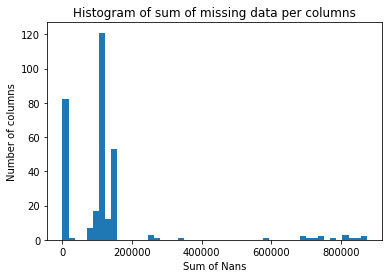

In [9]:
# histogram of the sum of missing values for the columns
plt.hist(azdias.isnull().sum(), bins = 50)
plt.title('Histogram of sum of missing data per columns')
plt.ylabel('Number of columns')
plt.xlabel('Sum of Nans')
;

In [10]:
azdias.isnull().sum().describe()

count       313.000000
mean     119829.536741
std      158201.982068
min           0.000000
25%        4854.000000
50%      105800.000000
75%      133324.000000
max      874745.000000
dtype: float64

**Looking further into more statistics, the average missing column values is about 98516, with some columns having 0 missing values and at the extreme end, maximum of 889061. Clearly such columns with so many missing values are not useful to me for analysis so will eventually be dropped.**

In [12]:
# Investigate patterns in the amount of missing data in each column.
for i in range(azdias.shape[1]):
    if azdias.iloc[:, i].isnull().sum() == 874745:
        print(azdias.columns[i])

D19_BANKEN_LOKAL


In [14]:
# Investigate patterns in the amount of missing data in each column.
for i in range(azdias.shape[1]):
    if azdias.iloc[:, i].isnull().sum() == 0:
        print(azdias.columns[i])

D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_HANDWERK
D19_HAUS_DEKO
D19_KOSMETIK
D19_NAHRUNGSERGAENZUNG
D19_SAMMELARTIKEL
D19_SCHUHE
D19_SONSTIGE
D19_TECHNIK
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_REST
D19_TIERARTIKEL
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_REST
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
D19_VERSI_DATUM
D19_VERSI_OFFLINE_DATUM
D19_VERSI_ONLINE_DATUM
D19_VERSICHERUNGEN
D19_VOLLSORTIMENT
D19_WEIN_FEINKOST
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
FINANZTYP
GEBURTSJAHR
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
SEMIO_DOM
SEMIO_ERL
SEMIO_FAM
SEMIO_KAEM
SEMIO_KRIT


In [16]:
# determing the outliers, cutoff at 200000 which is those columns with more than 20% missing values
outliers = []
for i in range(azdias.shape[1]):
    if azdias.iloc[:, i].isnull().sum() > 200000:
        outliers.append(azdias.columns[i])
print(outliers)

['AGER_TYP', 'ALTER_HH', 'ANZ_HH_TITEL', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_RATGEBER', 'D19_REISEN', 'D19_VERSAND_ONLINE_QUOTE_12', 'GREEN_AVANTGARDE', 'KK_KUNDENTYP']


**The columns; are considered outliers and will be dropped**

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(outliers, axis=1, inplace=True)

In [116]:
outliers


[]

In [97]:
# New dataset shape
azdias.shape

(891221, 293)

''

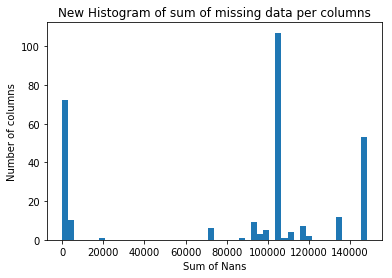

In [17]:
# plot of new histogram after dropping outliers
plt.hist(azdias.isnull().sum(), bins = 50)
plt.title('New Histogram of sum of missing data per columns')
plt.ylabel('Number of columns')
plt.xlabel('Sum of Nans')
;

#### Discussion 1.2.2: Assess Missing Data in Each Column
The average missing column values is about 119830, with some columns having 0 missing values and at the extreme end, maximum of 874745 missing value for one column. Most of the columns have 0 missing values and the rest are clustered between 100,000 and 120000, excluding the outliers(those with more than 200000 missing values).
The following columns were dropped from the dataset based on the cutoff value for missing column values of 200,000:

1. 'AGER_TYP'
2. 'ALTER_HH'
3. 'ANZ_HH_TITEL'
4. 'D19_BANKEN_DIREKT'
5. 'D19_BANKEN_GROSS'
6. 'D19_BANKEN_LOKAL'
7. 'D19_BANKEN_ONLINE_QUOTE_12'
8. 'D19_BANKEN_REST'
9. 'D19_BEKLEIDUNG_GEH'
10. 'D19_BEKLEIDUNG_REST'
11. 'D19_GESAMT_ONLINE_QUOTE_12'
12. 'D19_KINDERARTIKEL'
13. 'D19_KONSUMTYP'
14. 'D19_LEBENSMITTEL'
15. 'D19_LOTTO'
16. 'D19_RATGEBER'
17. 'D19_REISEN'
18. 'D19_VERSAND_ONLINE_QUOTE_12'
19. 'GREEN_AVANTGARDE'
20. 'KK_KUNDENTYP'

#### 1.2.3: Assess Missing Data for Each Row

In [18]:
# assess how much data is missing in each row of the dataset

azdias.isnull().sum(axis=1).describe()

count    891221.000000
mean         27.599917
std          64.756322
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         213.000000
dtype: float64

In [19]:
azdias.isnull().sum(axis=1).sum()

24597626

''

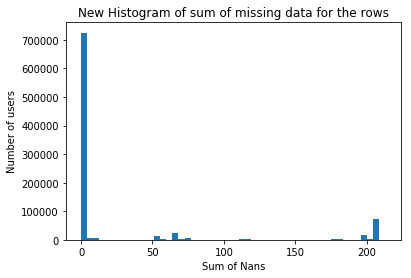

In [21]:
plt.hist(azdias.isnull().sum(axis=1), bins = 50)
plt.title('New Histogram of sum of missing data for the rows')
plt.ylabel('Number of users')
plt.xlabel('Sum of Nans')
;

In [18]:
sum_nans = azdias.isnull().sum(axis=1)


In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

above_cut_off = sum_nans[sum_nans > 30]
below_cut_off = sum_nans[sum_nans <=30]  

print('rows missing more than 30 column values:', above_cut_off.shape[0])
print('rows missing less than 30 column values:', below_cut_off.shape[0])

rows missing more than 30 column values: 153933
rows missing less than 30 column values: 737288


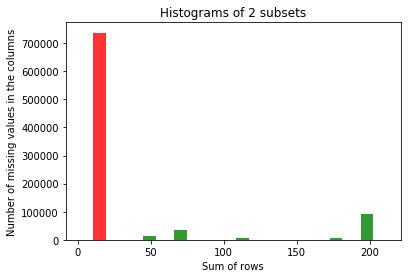

In [24]:

plt.hist([above_cut_off, below_cut_off], color=['g', 'r'], alpha=0.8)
plt.title('Histograms of 2 subsets')
plt.ylabel('Number of missing values in the columns')
plt.xlabel('Sum of rows')
plt.show()

In [20]:
# drop rows with more than 30 column values
azdias = azdias[~azdias.index.isin(above_cut_off.index)]

In [26]:
azdias.shape

(737288, 293)

#### 1:2.4: Select and Re-Encode Features

In [27]:
categorical_columns = feat_info.loc[feat_info['type']=='categorical', 'attribute'].values
categorical_columns

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'D19_KONSUMTYP',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_TELKO_ ANZ_12', 'D19_TELKO_ ANZ_24',
       'D19_VERSI_ ANZ_12 ', 'D19_VERSI_ ANZ_24', 'D19_VERSAND_ ANZ_12 ',
       'D19_VERSAND_ ANZ_24', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM',
       'D19_GESAM

In [28]:

# selecting columns with binary values
binary_cols = []


for i, j in enumerate(categorical_columns):
    
    if azdias.columns.isin([categorical_columns[i]]).sum() > 0:
        
        if len(set(azdias[categorical_columns[i]].values)) == 2:
            binary_cols.append(categorical_columns[i])
        else:
            continue

binary_cols

['ANREDE_KZ', 'SOHO_KZ', 'OST_WEST_KZ']

In [29]:
for c in binary_cols:
    print(azdias[c].value_counts())

2    384280
1    353008
Name: ANREDE_KZ, dtype: int64
0.0    731069
1.0      6219
Name: SOHO_KZ, dtype: int64
W    582290
O    154998
Name: OST_WEST_KZ, dtype: int64


In [21]:

# encode the binary columns to 1, 0 codes
azdias['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1,0], inplace=True)


In [43]:
azdias['SOHO_KZ'].replace([1.0, 0.0], [1,0], inplace=True)

In [31]:
for c in binary_cols:
    print(azdias[c].value_counts())

1    384280
0    353008
Name: ANREDE_KZ, dtype: int64
0.0    731069
1.0      6219
Name: SOHO_KZ, dtype: int64
1    582290
0    154998
Name: OST_WEST_KZ, dtype: int64


In [35]:
multi_cols = []


for i, j in enumerate(categorical_columns):
    
    if azdias.columns.isin([categorical_columns[i]]).sum() > 0:
        
        if len(set(azdias[categorical_columns[i]].values)) > 2:
            multi_cols.append(categorical_columns[i])
        else:
            continue

multi_cols

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_DATUM',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [ ]:
for c in binary_cols:
    print(azdias_df[c].value_counts())

In [36]:
for c in multi_cols:
    print(azdias[c].value_counts())

4.0    182291
3.0    135153
2.0    133759
5.0    104852
6.0     92101
1.0     84750
Name: CJT_GESAMTTYP, dtype: int64
6    279333
1    183268
5     98064
2     94276
4     52488
3     29859
Name: FINANZTYP, dtype: int64
12.0    118741
10.0     96584
8.0      77124
11.0     70649
5.0      67709
4.0      56673
3.0      51880
9.0      51656
1.0      47846
7.0      36607
2.0      32927
6.0      24510
Name: GFK_URLAUBERTYP, dtype: int64
1.0     371657
10.0    121768
2.0      91335
11.0     46211
0.0      24371
8.0      19575
7.0      16310
4.0      10485
5.0      10325
9.0       9797
6.0       6954
3.0       4118
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    371657
5.0    177776
2.0     91335
4.0     42839
3.0     24928
0.0     24371
Name: LP_FAMILIE_GROB, dtype: int64
1.0     193116
9.0     119084
2.0     106523
10.0    104699
4.0      70564
3.0      65286
6.0      26692
5.0      24412
8.0      13989
7.0       8541
Name: LP_STATUS_FEIN, dtype: int64
1.0    299639
2.0    160262
4.0    133073
5

In [22]:
cols_to_drop = ['D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM',
                'D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM','GEBAEUDETYP',
                'CAMEO_DEUG_2015','D19_TELKO_DATUM','D19_TELKO_ONLINE_DATUM', 'D19_TELKO_OFFLINE_DATUM',
                'D19_BANKEN_DATUM','D19_BANKEN_ONLINE_DATUM','D19_BANKEN_OFFLINE_DATUM','D19_GESAMT_DATUM',
                'D19_GESAMT_ONLINE_DATUM','D19_GESAMT_OFFLINE_DATUM','D19_BANKEN_ANZ_24','D19_BANKEN_ANZ_12',
                'D19_GESAMT_ANZ_24','D19_GESAMT_ANZ_12','ZABEOTYP','TITEL_KZ','LP_STATUS_FEIN','FINANZTYP',
                'CJT_GESAMTTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'CAMEO_INTL_2015','CAMEO_DEU_2015'] #more than 5 levels
cols_to_dummy = ['LP_FAMILIE_GROB','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','VERS_TYP']
 
 
 

 
 
 

In [23]:
# One-hot encoding to create dummy variables for the multi-level columns
azdias = pd.get_dummies(azdias, columns=cols_to_dummy)


In [16]:
azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,NATIONALITAET_KZ_0,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
1,11.0,2.0,0.0,3.0,6.0,8A,8,51,5.0,0,...,0,1,0,0,0,0,0,1,0,1
2,10.0,1.0,0.0,3.0,2.0,4C,4,24,3.0,0,...,0,1,0,0,0,0,1,0,1,0
3,1.0,0.0,0.0,2.0,4.0,2A,2,12,2.0,0,...,0,1,0,0,0,1,0,0,1,0
4,3.0,4.0,0.0,4.0,2.0,6B,6,43,5.0,3,...,0,1,0,0,0,0,1,0,0,1
5,5.0,1.0,0.0,2.0,6.0,8C,8,54,2.0,0,...,0,1,0,0,1,0,0,0,0,1


In [17]:
azdias.columns

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'ANZ_TITEL', 'ARBEIT',
       'BALLRAUM', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12',
       ...
       'NATIONALITAET_KZ_0', 'NATIONALITAET_KZ_1', 'NATIONALITAET_KZ_2',
       'NATIONALITAET_KZ_3', 'SHOPPER_TYP_0.0', 'SHOPPER_TYP_1.0',
       'SHOPPER_TYP_2.0', 'SHOPPER_TYP_3.0', 'VERS_TYP_1.0', 'VERS_TYP_2.0'],
      dtype='object', length=309)

In [24]:
# drop columns that had more than 5 categorical values as including them was taking too long to run 
azdias.drop(cols_to_drop, axis=1, inplace=True)

In [80]:
azdias.columns

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'ANZ_TITEL', 'ARBEIT',
       'BALLRAUM', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
       ...
       'NATIONALITAET_KZ_0', 'NATIONALITAET_KZ_1', 'NATIONALITAET_KZ_2',
       'NATIONALITAET_KZ_3', 'SHOPPER_TYP_0.0', 'SHOPPER_TYP_1.0',
       'SHOPPER_TYP_2.0', 'SHOPPER_TYP_3.0', 'VERS_TYP_1.0', 'VERS_TYP_2.0'],
      dtype='object', length=279)

In [81]:
azdias.shape

(891221, 279)

- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). Creating two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.



In [25]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14
2,15
3,8
4,8
5,3


In [26]:
# creating the interval variable for decade
def Pra_decade(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
def pra_move(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1

In [27]:
# binary variable for movement 

azdias['Pra_j_dec'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(Pra_decade)
azdias['Pra_j_mov'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(pra_move)

In [28]:
azdias.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

In [29]:
# number or rows and columns in the final dataset
azdias.shape

(737288, 280)

<a id='clean'></a>
#### 1:3. Creating a Cleaning Function

In [13]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    def convert_missing_to_nan(df):
        for i,V in enumerate(df.iteritems()):
            missing_unknown = feat_info['missing_or_unknown'][i]
            column_name = V[0]
            missing_unknown = missing_unknown[1:-1].split(',')
            if missing_unknown != ['']:
                hold = []
                for x in missing_unknown:
                    if x in ['X','XX']:
                        hold.append(x)
                    else:
                        hold.append(int(x))
                df[column_name] = df[column_name].replace(hold,np.nan)
            
        return df
    df = convert_missing_to_nan(df)
    
    # remove columns with >200000 missing values 
    outliers_list= ['AGER_TYP', 'ALTER_HH', 'ANZ_HH_TITEL', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 
                    'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 
                    'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_LEBENSMITTEL', 'D19_LOTTO', 
                    'D19_RATGEBER', 'D19_REISEN', 'D19_VERSAND_ONLINE_QUOTE_12', 'GREEN_AVANTGARDE', 'KK_KUNDENTYP']
    for col in outliers_list:
        df.drop(col, axis=1, inplace=True)

    
    
    sum_nans = df.isnull().sum(axis=1)
        
    #rows with more than 30 missing values
    above_cut_off = sum_nans[sum_nans > 30]
    
    #select only rows with less than 30 missing values 
    df = df[~df.index.isin(above_cut_off.index)]
    
    # binary and multi-level categorical columns

    # recoding binary variables
    df['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1,0], inplace=True)
    
    # multi_level categorical columns

    cols_to_drop = ['D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM',
                'D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM','GEBAEUDETYP',
                'CAMEO_DEUG_2015','D19_TELKO_DATUM','D19_TELKO_ONLINE_DATUM', 'D19_TELKO_OFFLINE_DATUM',
                'D19_BANKEN_DATUM','D19_BANKEN_ONLINE_DATUM','D19_BANKEN_OFFLINE_DATUM','D19_GESAMT_DATUM',
                'D19_GESAMT_ONLINE_DATUM','D19_GESAMT_OFFLINE_DATUM','D19_BANKEN_ANZ_24','D19_BANKEN_ANZ_12',
                'D19_GESAMT_ANZ_24','D19_GESAMT_ANZ_12','ZABEOTYP','TITEL_KZ','LP_STATUS_FEIN','FINANZTYP',
                'CJT_GESAMTTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'CAMEO_INTL_2015','CAMEO_DEU_2015'] #more than 5 levels
    cols_to_dummy = ['LP_FAMILIE_GROB','LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','VERS_TYP']

    df = pd.get_dummies(df, columns=cols_to_dummy) #one hot encoding
                    
    df.drop(cols_to_drop, axis=1, inplace=True) #drop all columns with more than 5 categorical values
    
    # select, re-encode, and engineer column values.
      # binary variable for movement 
    # creating the interval variable for decade
 
    def Pra_decade(x):
        if x in (1,2):
            return 1
        if x in (3,4):
            return 2
        if x in (5,6,7):
            return 3
        if x in (8,9):
            return 4
        if x in (10,11,12,13):
            return 5
        if x in (14,15):
            return 6
    
    def pra_move(x):
        if x in (2,4,6,7,9,11,13,15):
            return 0
        if x in (1,3,5,8,10,12,14):
            return 1

    df['Pra_j_dec'] = df['PRAEGENDE_JUGENDJAHRE'].apply(Pra_decade)
    df['Pra_j_mov'] = df['PRAEGENDE_JUGENDJAHRE'].apply(pra_move)

    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

    
    # Return the cleaned dataframe.
    
    return df

<a id='feature'></a>
### 2. Feature Transformation

In [32]:
# I used the imputer to fill in missing values and applied the standard scaler in order to transform the data such that the ditribution has a mean of 0 and standard deviation of 1.  

imp = Imputer()
imputed_features=imp.fit_transform(azdias)

azdias_new_df = pd.DataFrame(imputed_features, columns = azdias.columns)

scaler = StandardScaler()
azdias_scaled_arr = scaler.fit_transform(azdias_new_df)

azdias_scaled = pd.DataFrame(azdias_scaled_arr, columns = azdias.columns, index = azdias.index)

In [33]:
azdias_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,Pra_j_dec,Pra_j_mov
1,0.182840,0.224688,-0.06066,-0.179038,0.850352,-0.311651,-0.216695,-0.664781,-0.197125,-0.399911,...,-0.295836,-0.205764,-0.448850,-0.658336,-0.601069,1.891938,-0.907560,0.995693,1.173303,0.554885
2,0.116586,-0.634469,-0.06066,-0.179038,-0.980167,3.192098,-0.216695,-0.664781,-0.197125,-0.399911,...,-0.295836,-0.205764,-0.448850,-0.658336,1.663701,-0.528559,1.101855,-1.004325,1.173303,-1.855496
3,-0.479700,-1.493626,-0.06066,-1.186817,-0.064907,-0.311651,-0.216695,1.621929,-0.197125,-0.399911,...,-0.295836,-0.205764,-0.448850,1.518982,-0.601069,-0.528559,1.101855,-1.004325,-0.216042,0.554885
4,-0.347192,1.943002,-0.06066,0.828741,-0.980167,3.192098,-0.216695,1.621929,-0.197125,0.152589,...,-0.295836,-0.205764,-0.448850,-0.658336,1.663701,-0.528559,-0.907560,0.995693,-0.216042,0.554885
5,-0.214684,-0.634469,-0.06066,-1.186817,0.850352,-0.311651,-0.216695,-0.664781,-0.197125,-0.399911,...,-0.295836,-0.205764,2.227918,-0.658336,-0.601069,-0.528559,-0.907560,0.995693,-1.605387,0.554885


In [ ]:
pickle.dump(azdias_scaled, open("azdias_scaled.pickle", "wb"))

<a id='reduction'></a>
#### 2:1. Dimesionality Reduction

In [61]:
# Apply PCA to the data.
pca = PCA(100)

azdias_pca = pca.fit_transform(azdias_scaled)

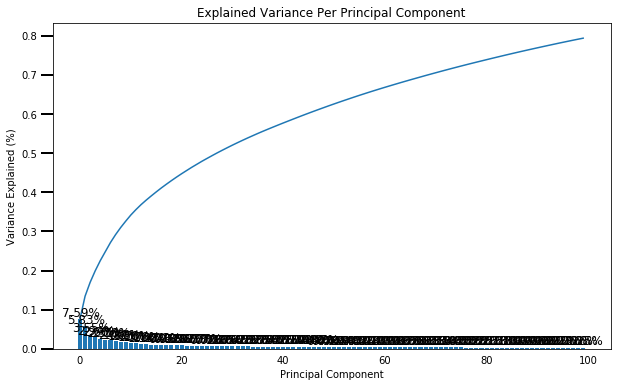

In [64]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)


In [62]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_10 = PCA(n_components  = 10)
azdias_pca_10 = pca_10.fit_transform(azdias_scaled)




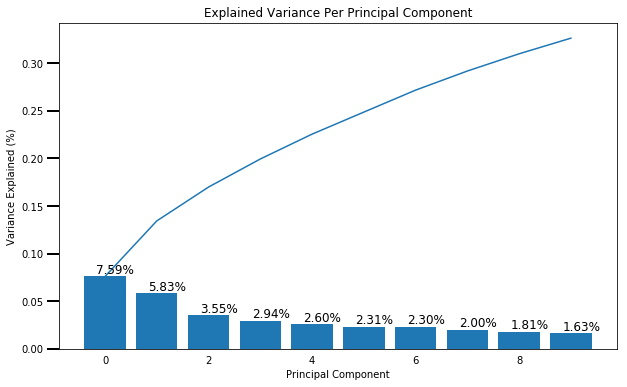

In [65]:
scree_plot(pca_10)

#### Discussion 2.1. Perform Dimensionality Reduction

**I selected only 10 transformed features to retain mostly because of the size of the dataset and the amount of time my machine was taking to run for components larger than 10 while processing at the clustering step. At least 35% of the variance is explained by each component.**

<a id='principal'></a>
#### 2.2. Principal Components Interpretation

In [66]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_features(data, pca, pc_num):
  
    p_comp = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[pc_num]
    p_comp.sort_values(ascending=False, inplace=True)
    p_comp = pd.concat([p_comp.head(5), p_comp.tail(5)])
    
    p_comp.plot(kind='bar', title='Principal Component ' + str(pc_num))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()


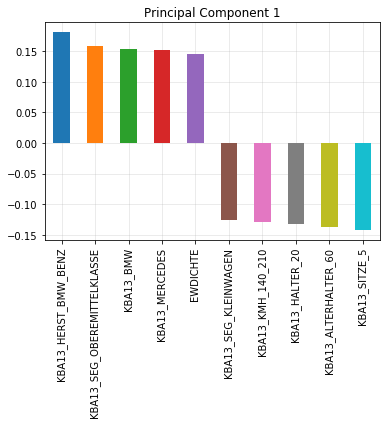

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight
plot_features(azdias_scaled, pca_10, pc_num=1)

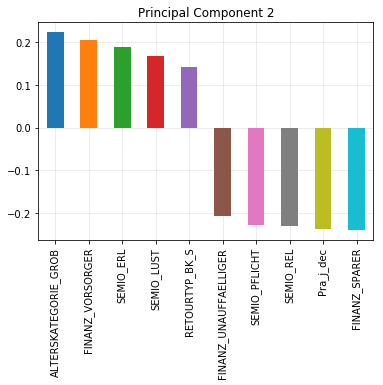

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_features(azdias_scaled, pca_10, pc_num=2)

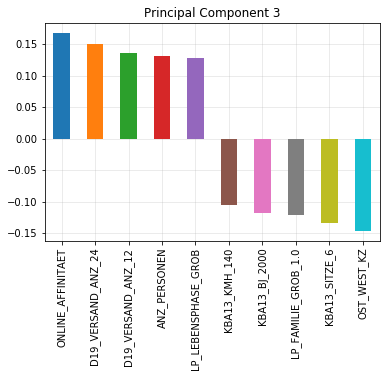

In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_features(azdias_scaled, pca_10, pc_num=3)

#### Discussion 2.3: Interpret Principal Components

Interpreting principal components is based on finding out which variables are correlated with each component. For those variables that are positively correlated to a principal component, it means that they vary together in such as if one increases the other variables increase as well. 
**The first pricipal component is postively correlated to:**
1. KBA13_HERST_BMW_BENZ - share of BMW & Mercedes Benz within the PLZ8
2. KBA13_BMW - share of BMW within the PLZ8
3. KBA13_MERCEDES - share of MERCEDES within the PLZ8
4. KBA13_SEG_OBEREMITTELKLASSE - share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
5. EWDICHTE - density of inhabitants per square kilometer

Upper middle class cars are mostly comprised of BMW and Mercedes and car owners belo 21 tend to have cars with less than 5 seats
**and negatively correlated to:**
1. KBA13_SEG_KLEINWAGEN - share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8
2. KBA13_KMH_140_210 - share of cars with max speed between 140 and 210 km/h within the PLZ8
3. KBA13_HALTER_20 - share of car owners below 21 within the PLZ8
4. KBA13_ALTERHALTER_60 - share of car owners between 46 and 60 within the PLZ8
5. KBA13_SITZE_5 - number of cars with 5 seats in the PLZ8



**The second  pricipal component is postively correlated to:**
1. ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
2. FINANZ_VORSORGER: be prepared
3. SEMIO_REL - religious
4. SEMIO_LUST - sensual - minded
5. RETOURTYP_BK_S - Return type

**and negatively correlated to:**
1. FINANZ_SPARER money-saver
2. FINANZ_UNAUFFAELLIGER inconspicuous
3. SEMIO_ERL - event-oriented
4. SEMIO_PFLICHT - dutiful
5. Pra_j_dec - movement by decade

The second component is linked mostly to personality types; individuals that are religious, tend to be socially and cultural minded while those that are event oriented are also dutiful and money savers.
**The third pricipal component is postively correlated to:**
1. ONLINE_AFFINITAET - online affinity
2. D_19_VERSAND_ANZ_12 - transaction activity in the last 12 months
3. D_19_VERSAND_ANZ_24 - transaction activity in the last 24 months
4. LP_LEBENSPHASE_GROB - rough lifestage
6. ANZ_PERSONEN - Number of adults in household

**and negatively correlated to:**
1. OST_WEST_KZ - Building location via former East / West Germany (GDR / FRG)
2. KBA13_BJ_2000 - share of cars build between 2000 and 2003 within the PLZ8
3. KBA13_KMH_140 -share of cars with max speed between 110 km/h and 140km/h within the PLZ8
4. LP_FAMILIE_GROB - single family type
5. KBA13_SITZE_6 - number of cars with more than 5 seats in the PLZ8


The third principal component contains a mixed array of variables consisting of lifestage, online affinity and transaction activity, family type and number of households in a household. Increase in the number of adults in the household also increases online affinity. Based on those variables that are negatively correlated to the component, single family members tend to have cars with less than 5 seats, have cars with a higher speeds and have less cars build between 2000 and 2003. 

<a id='clustering'></a>
### 3. Clustering

<a id='kmeans'></a>
#### 3:1. Applying Clustering to General Pupulation Data using k-means

Text(0.5,1,'SSE vs K')

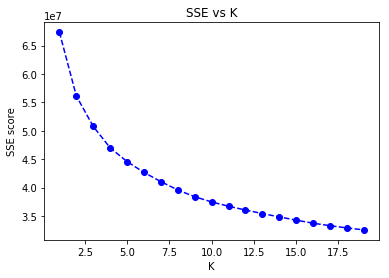

In [70]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
start_time = time.time()    
    # compute the average within-cluster distances.
def fit_kmeans(data, centers):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    
    '''
    kmeans = KMeans(n_clusters = center)
    model = kmeans.fit(data)
    # SSE score for kmeans model 
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(1,20))
for center in centers:
    scores.append(fit_kmeans(azdias_pca_10, center))
    
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plot the original data with clusters
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.ylabel('SSE score')
plt.xlabel('K')
plt.title('SSE vs K')


In [71]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 8)
new_model = kmeans.fit(azdias_pca_10)
clust_preds = new_model.predict(azdias_pca_10)

<a id='customer'></a>
#### 3:2. Applying all Steps to Customer Data

In [73]:
# Load in the customer demographics data.
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [74]:
customers.shape

(191652, 369)

In [75]:
customers.drop(labels=diff_not_in_customers, axis=1, inplace=True)

In [76]:
customers.shape

(191652, 313)

In [77]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
customers_clean.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(134246, 280)

In [57]:
# display the first 5 columns of the customers data 
customers_clean.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,Pra_j_dec,Pra_j_mov
0,1.0,2.0,0.0,1.0,3.0,0,0,6,0,0,...,0,0,0,0,0,1,1,0,2.0,0.0
2,1.0,1.0,0.0,3.0,7.0,6,0,0,0,0,...,0,0,0,1,0,0,0,1,2.0,0.0
3,NaN,0.0,0.0,1.0,7.0,0,0,6,0,0,...,0,0,1,0,0,0,1,0,1.0,1.0
4,7.0,4.0,0.0,3.0,3.0,0,0,2,0,4,...,0,0,0,1,0,0,0,1,4.0,1.0
5,1.0,2.0,0.0,3.0,7.0,0,0,5,0,0,...,0,0,0,1,0,0,0,1,2.0,0.0


In [78]:
# compare the column list of the azdias and customer data 
list(set(azdias.columns) - set(customers_clean))

[]

In [59]:
# add the missing column to the customers data and label it 0 
customers_clean['GEBAEUDETYP_5.0'] = 0


In [60]:
customers_clean.shape

(134246, 281)

In [79]:
# applying the imputer in the customers data
customers_clean_imp=imp.transform(customers_clean)

In [80]:
# applying deature scaling 

customers_clean_df = pd.DataFrame(customers_clean_imp, columns = customers_clean.columns)

customers_scaled_arr = scaler.transform(customers_clean_df)

customers_scaled = pd.DataFrame(customers_scaled_arr, columns = customers_clean.columns, index = customers_clean.index)

In [81]:
customers_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,Pra_j_dec,Pra_j_mov
0,-4.797005e-01,0.224688,-0.06066,-2.194597,-0.522537,-0.311651,-0.216695,1.621929,-0.197125,-0.399911,...,-0.295836,-0.205764,-0.448850,-0.658336,-0.601069,1.891938,1.101855,-1.004325,-1.605387,-1.855496
2,-4.797005e-01,-0.634469,-0.06066,-0.179038,1.307982,3.192098,-0.216695,-0.664781,-0.197125,-0.399911,...,-0.295836,-0.205764,-0.448850,1.518982,-0.601069,-0.528559,-0.907560,0.995693,-1.605387,-1.855496
3,-1.176909e-16,-1.493626,-0.06066,-2.194597,1.307982,-0.311651,-0.216695,1.621929,-0.197125,-0.399911,...,-0.295836,-0.205764,2.227918,-0.658336,-0.601069,-0.528559,1.101855,-1.004325,-2.300059,0.554885
4,-8.217589e-02,1.943002,-0.06066,-0.179038,-0.522537,-0.311651,-0.216695,0.097455,-0.197125,1.810089,...,-0.295836,-0.205764,-0.448850,1.518982,-0.601069,-0.528559,-0.907560,0.995693,-0.216042,0.554885
5,-4.797005e-01,0.224688,-0.06066,-0.179038,1.307982,-0.311651,-0.216695,1.240810,-0.197125,-0.399911,...,-0.295836,-0.205764,-0.448850,1.518982,-0.601069,-0.528559,-0.907560,0.995693,-1.605387,-1.855496


In [82]:
#transform the customers using pca
customers_pca = pca_10.transform(customers_scaled)
#predict clustering using the kmeans
predict_customers = new_model.predict(customers_pca)

In [83]:
centers = new_model.cluster_centers_

In [84]:
centers.shape

(8, 10)

<a id='compare'></a>
#### 3.3. Compare Customer Data to General Population Data

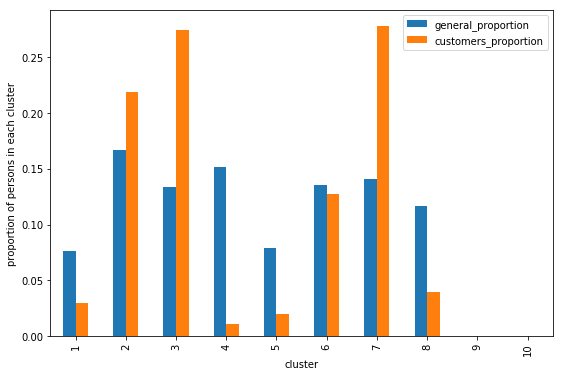

In [85]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_pop = []
customers_pop = []
x = [i+1 for i in range(10)]
for i in range(10):
    general_pop.append((clust_preds == i).sum()/len(clust_preds))
    customers_pop.append((predict_customers == i).sum()/len(predict_customers))


df_general = pd.DataFrame({'cluster' : x, 'general_proportion' : general_pop, 'customers_proportion':customers_pop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['general_proportion', 'customers_proportion'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

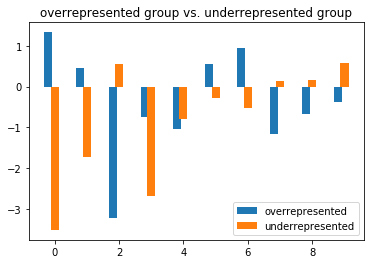

In [86]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

Centers_pl = np.arange(0,10)

ax1 = plt.subplot(111)
ax1.bar(Centers_pl - 0.2,centers[3][0:10], width = 0.25)
ax1.bar(Centers_pl,centers[1][0:10], width = 0.25)
ax1.set_title('overrepresented group vs. underrepresented group')
plt.legend(['overrepresented','underrepresented'])
plt.show()

In [89]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centers_inverse = scaler.inverse_transform(pca_10.inverse_transform(centers))
centers_df = pd.DataFrame(centers_inverse, columns = azdias_scaled.columns)
overrepresented = centers_df.loc[6]
underrepresented = centers_df.loc[1]

In [92]:
# interested variables for comparison 
interested_variables = [ 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_SPARER', 'FINANZ_HAUSBAUER','FINANZ_MINIMALIST' ]

In [93]:

print("Feature.......Overrepresented.......Underrepresented")
for x in interested_variables:
    print(f"{x}.......{overrepresented[x]}.......{underrepresented[x]}")

Feature.......Overrepresented.......Underrepresented
FINANZ_VORSORGER.......3.3958968063753083.......4.099966595377492
FINANZ_ANLEGER.......3.0564004130700737.......2.531990780990272
FINANZ_SPARER.......2.695366429471275.......1.975674838143373
FINANZ_HAUSBAUER.......2.069826950256215.......2.5515110319171677
FINANZ_MINIMALIST.......3.8295440805804613.......3.9521727732643157


### Discussion 3.3: Compare Customer Data to Demographics Data

**For my feature analysis comparing those underrepresented and overrepresented in cluster 1 and 9, I was interested in individual financial types thus included 6 variables in my analysis:**
1. 'FINANZ_VORSORGER' (individual financial type for those that are prepared)
2. 'FINANZ_ANLEGER'(individual financial type for Investors)
3. 'LP_LEBENSPHASE_FEIN'(life stage)
4. 'FINANZ_HAUSBAUER'(individual financial type for house owners)
5. 'FINANZ_MINIMALIST' (those with low financial interest)
6. 'FINANZ_SPARER' (money-savers)


**The cluster that had overrepresented customer data, consisted of individuals that are more likely to be investors and more likely to be money savers.**

**Those in the underrepresented cluster are more likely to own homes, have low financial interest and are more likely to be prepared.** 

**Using this analysis based on the different clusters and the characteristics of individuals in these clusters, Bertelsmann Arvato Analytics can target specific segments of the population for their marketing campaigns that will yield the highest expected rate of returns.** 

<a id='model'></a>
### 4. Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [131]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

mailout_train.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [132]:
diff_not_in_mailout = list(set(mailout_train) - set(feat_list))
print('Features in mailout that are not in feat_list:')
print(len(diff_not_in_mailout))
print(diff_not_in_mailout)
print('***')

Features in mailout that are not in feat_list:
54
['DSL_FLAG', 'RT_KEIN_ANREIZ', 'D19_TELKO_ONLINE_QUOTE_12', 'KBA13_GBZ', 'LNR', 'EXTSEL992', 'KBA13_ANTG3', 'KBA13_HHZ', 'ALTERSKATEGORIE_FEIN', 'CJT_TYP_3', 'RESPONSE', 'KBA13_ANTG4', 'RT_UEBERGROESSE', 'RT_SCHNAEPPCHEN', 'GEMEINDETYP', 'CJT_TYP_6', 'KBA13_ANTG1', 'VHA', 'ANZ_STATISTISCHE_HAUSHALTE', 'UNGLEICHENN_FLAG', 'EINGEFUEGT_AM', 'STRUKTURTYP', 'CJT_KATALOGNUTZER', 'MOBI_RASTER', 'AKT_DAT_KL', 'CJT_TYP_1', 'VHN', 'CJT_TYP_4', 'ANZ_KINDER', 'VK_DISTANZ', 'HH_DELTA_FLAG', 'KBA13_KMH_210', 'D19_KONSUMTYP_MAX', 'KBA13_ANTG2', 'CJT_TYP_5', 'VK_DHT4A', 'KONSUMZELLE', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND3', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_2', 'KOMBIALTER', 'D19_SOZIALES', 'UMFELD_ALT', 'FIRMENDICHTE', 'UMFELD_JUNG', 'VERDICHTUNGSRAUM', 'VK_ZG11', 'KBA13_BAUMAX', 'EINGEZOGENAM_HH_JAHR', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND4', 'KBA13_CCM_1401_2500']
***


In [134]:
cols_to_drop_m = ['DSL_FLAG', 'RT_KEIN_ANREIZ', 'D19_TELKO_ONLINE_QUOTE_12', 'KBA13_GBZ', 'LNR', 'EXTSEL992', 'KBA13_ANTG3', 'KBA13_HHZ', 'ALTERSKATEGORIE_FEIN', 'CJT_TYP_3', 'KBA13_ANTG4', 'RT_UEBERGROESSE', 'RT_SCHNAEPPCHEN', 'GEMEINDETYP', 'CJT_TYP_6', 'KBA13_ANTG1', 'VHA', 'ANZ_STATISTISCHE_HAUSHALTE', 'UNGLEICHENN_FLAG', 'EINGEFUEGT_AM', 'STRUKTURTYP', 'CJT_KATALOGNUTZER', 'MOBI_RASTER', 'AKT_DAT_KL', 'CJT_TYP_1', 'VHN', 'CJT_TYP_4', 'ANZ_KINDER', 'VK_DISTANZ', 'HH_DELTA_FLAG', 'KBA13_KMH_210', 'D19_KONSUMTYP_MAX', 'KBA13_ANTG2', 'CJT_TYP_5', 'VK_DHT4A', 'KONSUMZELLE', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND3', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_2', 'KOMBIALTER', 'D19_SOZIALES', 'UMFELD_ALT', 'FIRMENDICHTE', 'UMFELD_JUNG', 'VERDICHTUNGSRAUM', 'VK_ZG11', 'KBA13_BAUMAX', 'EINGEZOGENAM_HH_JAHR', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND4', 'KBA13_CCM_1401_2500']

In [135]:
mailout_train.drop(labels=cols_to_drop_m, axis=1, inplace=True)

In [136]:
mailout_train.shape

(42962, 314)

In [ ]:
# Define the labels (y) to be the response column, and the rest of the columns to be X
y = mailout_train['RESPONSE']
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [137]:
# Clean the training data 
mailout_train = clean_data(mailout_train)
mailout_train.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,Pra_j_dec,Pra_j_mov
0,15.0,1.0,0.0,3.0,5.0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1.0,1.0
1,1.0,2.0,0.0,2.0,5.0,0,0,0,0,6,...,1,0,0,0,1,0,1,0,4.0,1.0
2,NaN,0.0,0.0,4.0,1.0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1.0,0.0
3,4.0,2.0,0.0,4.0,2.0,0,0,6,0,0,...,0,0,0,1,0,0,0,1,1.0,0.0
4,53.0,1.0,0.0,3.0,4.0,7,0,0,0,0,...,0,0,0,1,0,0,1,0,2.0,1.0


In [138]:
# Define the labels (y) to be the response column, and the rest of the columns to be X
y = mailout_train['RESPONSE']
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [139]:
y.value_counts()

0    33421
1      416
Name: RESPONSE, dtype: int64

In [26]:

mailout_train.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,Pra_j_dec,Pra_j_mov
0,15.000000,1.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
1,1.000000,2.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,6.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0
2,6.631345,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,4.000000,2.0,0.0,4.0,2.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,53.000000,1.0,0.0,3.0,4.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0


In [140]:
# Apply feature scaling to the train df
imp = Imputer()
mailout_imp=imp.fit_transform(mailout_train)

mailout_df = pd.DataFrame(mailout_imp, columns = mailout_train.columns)

scaler = StandardScaler()
mailout_scaled_arr = scaler.fit_transform(mailout_df)

mailout_scaled = pd.DataFrame(mailout_scaled_arr, columns = mailout_train.columns, index = mailout_train.index)


In [141]:
mailout_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,Pra_j_dec,Pra_j_mov
0,5.645053e-01,-0.757329,-0.091169,-0.040938,0.336934,-0.509629,-0.375653,-1.063578,-0.214655,-0.427056,...,-0.142130,-0.119195,-0.463417,-0.586667,-0.465110,1.284174,-1.005839,1.029912,-1.317996,0.738358
1,-3.798608e-01,-0.024851,-0.091169,-1.009639,0.336934,-0.509629,-0.375653,-1.063578,-0.214655,2.715678,...,7.035836,-0.119195,-0.463417,-0.586667,2.150031,-0.778711,0.994195,-0.970957,0.885633,0.738358
2,-5.991183e-17,-1.489807,-0.091169,0.927763,-1.487340,-0.509629,-0.375653,-1.063578,-0.214655,-0.427056,...,-0.142130,-0.119195,-0.463417,-0.586667,-0.465110,1.284174,0.994195,-0.970957,-1.317996,-1.361600
3,-1.774967e-01,-0.024851,-0.091169,0.927763,-1.031271,-0.509629,-0.375653,1.040426,-0.214655,-0.427056,...,-0.142130,-0.119195,-0.463417,1.704544,-0.465110,-0.778711,-1.005839,1.029912,-1.317996,-1.361600
4,3.127785e+00,-0.757329,-0.091169,-0.040938,-0.119134,2.412286,-0.375653,-1.063578,-0.214655,-0.427056,...,-0.142130,-0.119195,-0.463417,1.704544,-0.465110,-0.778711,0.994195,-0.970957,-0.583453,0.738358


<a id='training'></a>
### 4.1 Model Training

In [142]:
def classifier_grid(clf, param_grid, X_train=mailout_scaled, y_train=y):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [143]:

# LogisticRegression
clf_a = LogisticRegression(random_state=12)
classifier_grid(clf_a, {})

0.587993692143


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [145]:
# RandomForestClassifier
clf_b = RandomForestClassifier(random_state=12)
classifier_grid(clf_b, {})

0.498544731883


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

In [39]:
# GradientBoostingClassifier
clf_c = GradientBoostingClassifier(random_state=12)
classifier_grid(clf_c, {})

0.548190249466


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=12, subsample=1.0, verbose=0,
              warm_start=False)

In [37]:
# AdaBoostClassifier
clf_d = AdaBoostClassifier(random_state=12)
classifier_grid(clf_d, {})

0.543607673822


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=12)

<a id='tuning'></a>
### 4.2 Model Tuning

In [147]:
# initialize the best classifier
clf = GradientBoostingClassifier(random_state=12)
param_grid = {"learning_rate": [0.1], 
              "loss": ['deviance'], 
              "max_features": [6]
             }


clf_best_est = classifier_grid(clf, param_grid)
clf_best_est

0.558805586645


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=6, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=12, subsample=1.0, verbose=0,
              warm_start=False)

In [150]:
clf_a = AdaBoostClassifier(random_state=12)
param_grid = {'n_estimators':[50,100],
             'learning_rate': [1.0, 0.05]
             }


clf_a_best_est = classifier_grid(clf_a, param_grid)
clf_a_best_est

0.572817422953


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=12)

<a id='importance'></a>
### 4.3 Feature Importance

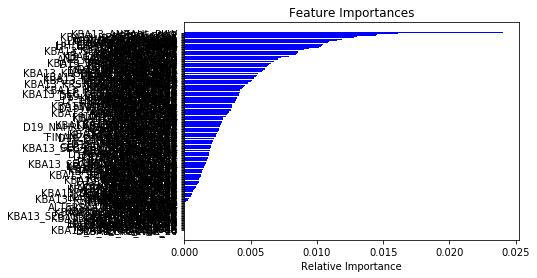

In [148]:
features = mailout_scaled.columns[:mailout_scaled.shape[1]]
importances = clf_best_est.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');

In [149]:
fi = pd.DataFrame({'FI':clf_best_est.feature_importances_}, index=mailout_train.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
KBA13_ANZAHL_PKW,0.024039
KBA05_KW2,0.016155
Pra_j_dec,0.014972
KBA05_SEG2,0.014551
KBA13_HERST_EUROPA,0.014428
D19_SONSTIGE,0.013132
W_KEIT_KIND_HH,0.013064
KBA13_KW_60,0.012766
MIN_GEBAEUDEJAHR,0.012729
KBA13_HERST_ASIEN,0.012492


In [151]:
fi = pd.DataFrame({'FI':clf_a_best_est.feature_importances_}, index=mailout_train.columns)
fi_sorted = fi.sort_values(by=['FI'], ascending=False)
fi_sorted.head(10)

,FI
ANZ_HAUSHALTE_AKTIV,0.03
SEMIO_FAM,0.02
KBA05_ANHANG,0.02
KBA05_ZUL4,0.02
KBA13_BJ_2004,0.02
KBA13_CCM_1200,0.02
KBA13_CCM_1400,0.02
D19_SAMMELARTIKEL,0.02
KBA05_HERST3,0.02
SEMIO_VERT,0.01


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [169]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [170]:
diff_not_in_mailout_test = list(set(mailout_test) - set(feat_list))
print('Features in mailout test that are not in feat_list:')
print(len(diff_not_in_mailout_test))
print(diff_not_in_mailout_test)
print('***')

Features in mailout test that are not in feat_list:
53
['DSL_FLAG', 'RT_KEIN_ANREIZ', 'D19_TELKO_ONLINE_QUOTE_12', 'KBA13_GBZ', 'LNR', 'EXTSEL992', 'KBA13_ANTG3', 'KBA13_HHZ', 'ALTERSKATEGORIE_FEIN', 'CJT_TYP_3', 'KBA13_ANTG4', 'RT_UEBERGROESSE', 'RT_SCHNAEPPCHEN', 'GEMEINDETYP', 'CJT_TYP_6', 'KBA13_ANTG1', 'VHA', 'ANZ_STATISTISCHE_HAUSHALTE', 'UNGLEICHENN_FLAG', 'EINGEFUEGT_AM', 'STRUKTURTYP', 'CJT_KATALOGNUTZER', 'MOBI_RASTER', 'AKT_DAT_KL', 'CJT_TYP_1', 'VHN', 'CJT_TYP_4', 'ANZ_KINDER', 'VK_DISTANZ', 'HH_DELTA_FLAG', 'KBA13_KMH_210', 'D19_KONSUMTYP_MAX', 'KBA13_ANTG2', 'CJT_TYP_5', 'VK_DHT4A', 'KONSUMZELLE', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND3', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_2', 'KOMBIALTER', 'D19_SOZIALES', 'UMFELD_ALT', 'FIRMENDICHTE', 'UMFELD_JUNG', 'VERDICHTUNGSRAUM', 'VK_ZG11', 'KBA13_BAUMAX', 'EINGEZOGENAM_HH_JAHR', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND4', 'KBA13_CCM_1401_2500']
***


In [171]:
cols_to_drop_test = ['DSL_FLAG', 'RT_KEIN_ANREIZ', 'D19_TELKO_ONLINE_QUOTE_12', 'KBA13_GBZ','EXTSEL992', 'KBA13_ANTG3', 'KBA13_HHZ', 'ALTERSKATEGORIE_FEIN', 'CJT_TYP_3', 'KBA13_ANTG4', 'RT_UEBERGROESSE', 'RT_SCHNAEPPCHEN', 'GEMEINDETYP', 'CJT_TYP_6', 'KBA13_ANTG1', 'VHA', 'ANZ_STATISTISCHE_HAUSHALTE', 'UNGLEICHENN_FLAG', 'EINGEFUEGT_AM', 'STRUKTURTYP', 'CJT_KATALOGNUTZER', 'MOBI_RASTER', 'AKT_DAT_KL', 'CJT_TYP_1', 'VHN', 'CJT_TYP_4', 'ANZ_KINDER', 'VK_DISTANZ', 'HH_DELTA_FLAG', 'KBA13_KMH_210', 'D19_KONSUMTYP_MAX', 'KBA13_ANTG2', 'CJT_TYP_5', 'VK_DHT4A', 'KONSUMZELLE', 'D19_VERSI_ONLINE_QUOTE_12', 'ALTER_KIND3', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_2', 'KOMBIALTER', 'D19_SOZIALES', 'UMFELD_ALT', 'FIRMENDICHTE', 'UMFELD_JUNG', 'VERDICHTUNGSRAUM', 'VK_ZG11', 'KBA13_BAUMAX', 'EINGEZOGENAM_HH_JAHR', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND4', 'KBA13_CCM_1401_2500']

In [172]:
mailout_test.drop(labels=cols_to_drop_test, axis=1, inplace=True)

In [173]:
mailout_test.shape

(42833, 314)

In [174]:
# Clean the test data 
mailout_test = clean_data(mailout_test)
mailout_test.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,LNR,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,...,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,Pra_j_dec,Pra_j_mov
0,1754,2.0,2.0,0.0,3.0,6.0,0,0,0,0,...,0,0,0,0,0,1,1,0,1.0,0.0
1,1770,20.0,1.0,0.0,4.0,7.0,0,0,7,0,...,0,0,0,0,1,0,1,0,3.0,1.0
2,1465,2.0,4.0,0.0,4.0,1.0,0,0,6,0,...,0,0,0,0,0,1,1,0,3.0,0.0
3,1470,1.0,0.0,0.0,4.0,1.0,0,0,0,0,...,0,0,0,0,0,1,0,1,3.0,1.0
4,1478,1.0,4.0,0.0,3.0,6.0,5,0,3,0,...,0,0,0,0,0,1,1,0,4.0,1.0


In [175]:
# extract lnr
test_LNR = mailout_test['LNR']
mailout_test.drop(labels=['LNR'], axis=1, inplace=True)

In [180]:
test_LNR.shape

(33819,)

In [181]:
mailout_test.shape

(33819, 280)

In [176]:
# Apply feature scaling to the test df
imp = Imputer()
mailout_test_imp=imp.fit_transform(mailout_test)

mailout_test_df = pd.DataFrame(mailout_test_imp, columns = mailout_test.columns)

scaler = StandardScaler()
mailout_test_scaled_arr = scaler.fit_transform(mailout_test_df)

mailout_test_scaled = pd.DataFrame(mailout_test_scaled_arr, columns = mailout_test.columns, index = mailout_test.index)

In [182]:
mailout_test_scaled.shape

(33819, 280)

In [ ]:
def classifier_grid(clf, param_grid, X_train=mailout_test_scaled, y_train=test_LNR):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [ ]:
clf_a = AdaBoostClassifier(random_state=12)
param_grid = {'n_estimators':[50,100],
             'learning_rate': [1.0, 0.05]
             }


clf_a_best_est = classifier_grid(clf_a, param_grid)
clf_a_best_est

In [177]:
# use the trained model to predict the probabilties of the testing data 
preds = clf_a_best_est.predict_proba(mailout_test_scaled)
preds

array([[ 0.5093308 ,  0.4906692 ],
       [ 0.51219476,  0.48780524],
       [ 0.51243006,  0.48756994],
       ..., 
       [ 0.50993416,  0.49006584],
       [ 0.50414167,  0.49585833],
       [ 0.51421315,  0.48578685]])

In [184]:
# get a csv file to be submitted to Kaggle
# response column - probabilities of positive response.

kaggle = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':preds[:, 1]})
kaggle.to_csv('kaggle.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.490669
1,1770,0.487805
2,1465,0.487570
3,1470,0.486021
4,1478,0.484721


#### References

In [ ]:
https://github.com/Tobi81/nano_ds_capstone/blob/master/Arvato%20Project.ipynb